In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_and_clean_asset_data(asset_file_name, n=400):
    """Loads and cleans asset data from a CSV file."""
    asset = pd.read_csv(asset_file_name)
    asset['Date'] = pd.to_datetime(asset['Date'], errors='coerce')  
    asset[['Date', 'Close/Last', 'Open', 'High', 'Low']] = asset[['Date', 'Close/Last', 'Open', 'High', 'Low']].replace({r'\$': '', ',': ''}, regex=True)
    asset[['Close/Last', 'Open', 'High', 'Low']] = asset[['Close/Last', 'Open', 'High', 'Low']].astype(float)
    asset = asset.sort_values(by='Date', ascending=False).head(n).sort_values(by='Date', ascending=True)
    return asset

def calculate_asset_score(data):
    """Calculates asset score based on return, MAD, and EMA difference."""
    ret = (data['Close/Last'].iloc[:60] - data['Open'].iloc[:60]) / data['Open'].iloc[:60]
    avg_return = ret.mean()
    mad = np.mean(np.abs(ret) - avg_return)

    ema_diff = data['Close/Last'].iloc[:60].ewm(span=12, adjust=False).mean().iloc[-1] - \
               data['Close/Last'].iloc[:60].ewm(span=26, adjust=False).mean().iloc[-1]

    score = 0.4 * avg_return - 0.3 * mad + 0.3 * ema_diff
    return score, avg_return, mad, ema_diff

def knapsack_with_constraints(scores, mads, max_mad, min_score_threshold, assets):
    """Solves the knapsack problem with MAD constraint and score constraint."""
    n = len(scores)
    mad_scaled = [int(mad * 100) for mad in mads]  # Scale MADs to avoid float precision issues
    max_mad_scaled = int(max_mad * 100)  # Scale max MAD limit

    # DP table where dp[i][j] is the max score achievable using first i assets with MAD <= j
    dp = np.full((n + 1, max_mad_scaled + 1), -float('inf'))  # Initialize with -inf
    dp[0][0] = 0  # Base case: zero score with zero assets

    # Track selection of assets
    selected = [[[] for _ in range(max_mad_scaled + 1)] for _ in range(n + 1)]

    for i in range(1, n + 1):
        for j in range(max_mad_scaled + 1):
            # Case 1: Don't include asset i-1
            dp[i][j] = dp[i - 1][j]
            selected[i][j] = selected[i - 1][j].copy()

            # Case 2: Include asset i-1 (if it fits within MAD limit)
            if j >= mad_scaled[i - 1]:
                new_score = dp[i - 1][j - mad_scaled[i - 1]] + scores[i - 1]
                if new_score > dp[i][j]:
                    dp[i][j] = new_score
                    selected[i][j] = selected[i - 1][j - mad_scaled[i - 1]].copy()
                    selected[i][j].append(i - 1)

    # Find the best solution that meets the min_score_threshold
    best_selected, best_score = [], -float('inf')
    for j in range(max_mad_scaled + 1):
        if dp[n][j] >= min_score_threshold and dp[n][j] > best_score:
            best_selected, best_score = selected[n][j], dp[n][j]

    return [assets[i] for i in best_selected], best_score

def evaluate_predictions(all_asset_data, assets, max_mad=0.025, min_score_threshold=0.5):
    # Initialize confusion matrix
    confusion_matrix = {
        'True Positive': 0,  # Held stocks that went up
        'False Positive': 0,  # Held stocks that went down
        'True Negative': 0,  # Sold stocks that went down
        'False Negative': 0   # Sold stocks that went up
    }

    for j in range(5):  # Iterate through 5 periods
        period_scores = {}
        period_mads = {}
        end_values = {}

        # Calculate scores, MADs, and end_values for each asset
        for asset in assets:
            data = all_asset_data[asset]
            subset = data.iloc[j * 80: (j + 1) * 80].copy().reset_index(drop=True)
            
            # Calculate score + MAD
            score, avg_return, mad, ema_diff = calculate_asset_score(subset.iloc[:60])
            period_scores[asset] = score
            period_mads[asset] = mad

            # Calculate relative end value (from day 60 to 80)
            price_at_60 = subset['Close/Last'].iloc[60]
            price_at_80 = subset['Close/Last'].iloc[79]
            end_values[asset] = price_at_80 / price_at_60  # can be used later

        scores = np.array([period_scores[asset] for asset in assets])
        mads = np.array([period_mads[asset] for asset in assets])

        # Select assets using knapsack
        selected_assets, _ = knapsack_with_constraints(scores, mads, max_mad, min_score_threshold, assets)

        # Evaluate each asset's actual performance
        for asset in assets:
            data = all_asset_data[asset]
            subset = data.iloc[j * 80: (j + 1) * 80].copy().reset_index(drop=True)

            price_at_60 = subset['Close/Last'].iloc[59]
            price_at_80 = subset['Close/Last'].iloc[79]
            price_change = (price_at_80 - price_at_60) / price_at_60

            went_up = price_change > 0

            if asset in selected_assets:
                if went_up:
                    confusion_matrix['True Positive'] += 1
                else:
                    confusion_matrix['False Positive'] += 1
            else:
                if went_up:
                    confusion_matrix['False Negative'] += 1
                else:
                    confusion_matrix['True Negative'] += 1

    return confusion_matrix  

Period 1 Scores for Each Asset:
AAPL: -0.5246022851374486
AMZN: 0.5150879191430104
BABA: -0.4309931570368117
GOOGL: 0.7028219145583199
MSFT: 0.2947534820742388
Selected assets for period 1: ['AMZN', 'GOOGL', 'MSFT']
Period 2 Scores for Each Asset:
AAPL: -0.4797022340810797
AMZN: 0.5002539683670136
BABA: -0.31542305703903345
GOOGL: 0.520273807649297
MSFT: 1.0336393433790252
Selected assets for period 2: ['AMZN', 'GOOGL', 'MSFT']
Period 3 Scores for Each Asset:
AAPL: 0.7197430026602142
AMZN: 0.5689387435505949
BABA: 0.586730531283725
GOOGL: 1.4298851840557445
MSFT: -0.7495475936490084
Selected assets for period 3: ['AAPL', 'AMZN', 'BABA', 'GOOGL']
Period 4 Scores for Each Asset:
AAPL: 0.6610287807015403
AMZN: -0.3474242690243425
BABA: 0.3357474895582255
GOOGL: -0.7717494323912135
MSFT: -1.0289162468948279
Selected assets for period 4: ['AAPL', 'BABA']
Period 5 Scores for Each Asset:
AAPL: 1.880876137198743
AMZN: 1.7203265670271355
BABA: -0.5470508909411229
GOOGL: 1.7772376485138761
MSFT:

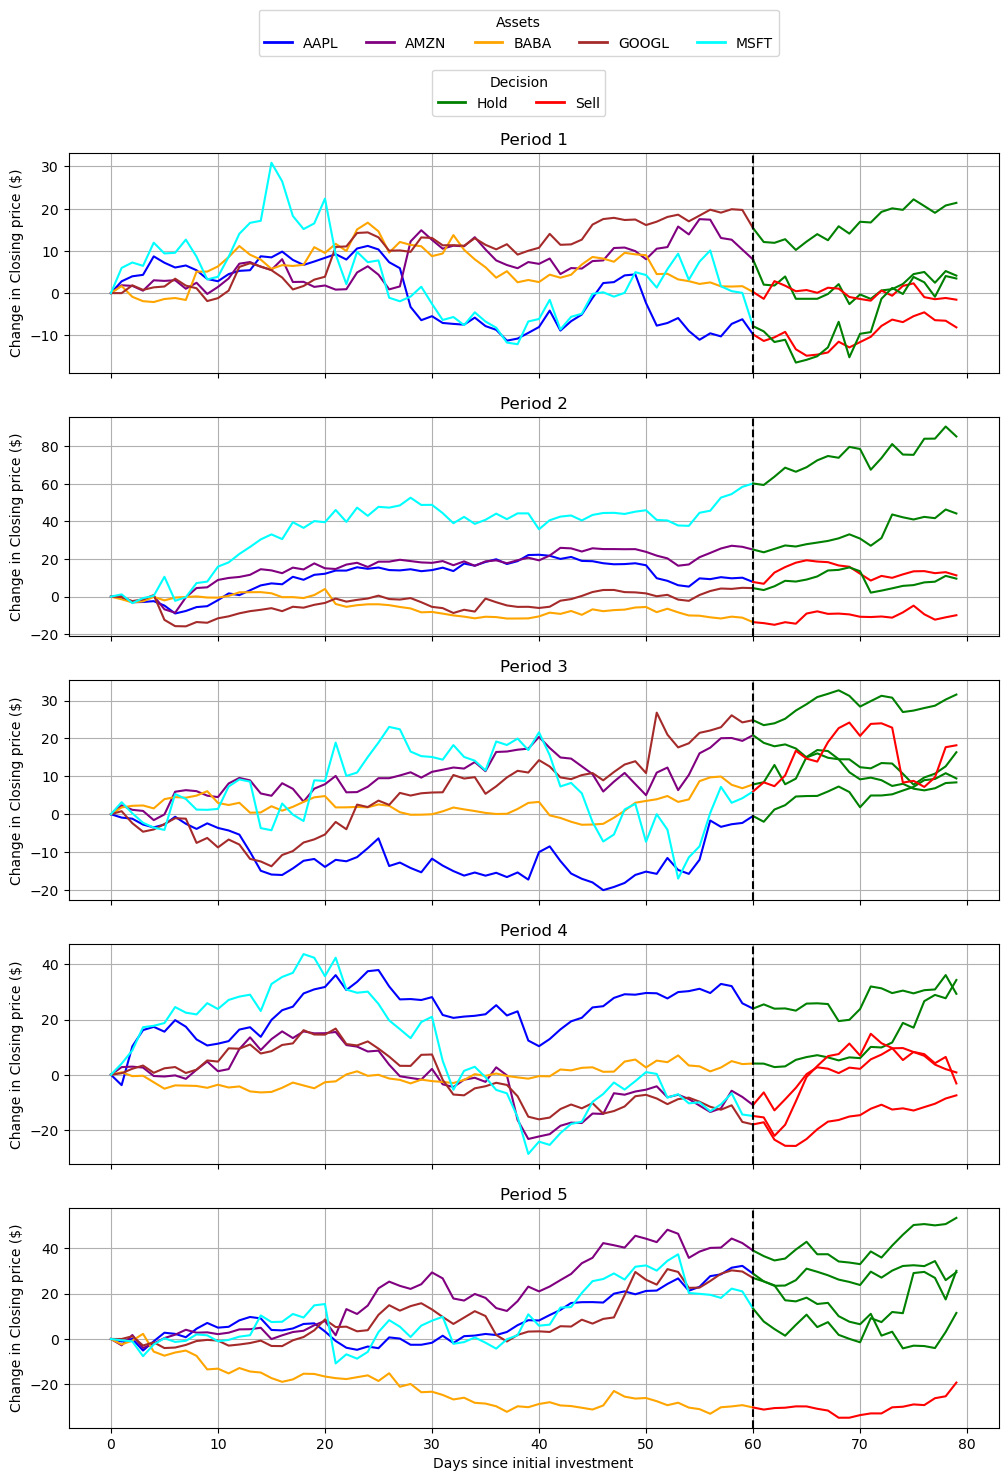

In [3]:
# Define assets and file names
assets = ['AAPL', 'AMZN', 'BABA', 'GOOGL', 'MSFT']
filenames = [f"data/{asset} - STOCK.csv" for asset in assets]
all_asset_data = {asset: load_and_clean_asset_data(filename) for asset, filename in zip(assets, filenames)}

# Define constraints
max_mad = 0.025  # Maximum MAD sum allowed
min_score_threshold = 0.5  # Minimum required score sum

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 15), sharex=True)
asset_colors = {'AAPL': 'blue', 'AMZN': 'purple', 'BABA': 'orange', 'GOOGL': 'brown', 'MSFT': 'cyan'}

for j in range(5):
    period_scores = {}
    period_mads = {}

    for asset in assets:
        data = all_asset_data[asset]
        subset = data.iloc[j * 80: (j + 1) * 80].copy().reset_index(drop=True)
        subset['Relative_Close'] = subset['Close/Last'] - subset['Close/Last'].iloc[0]

        score, avg_return, mad, ema_diff = calculate_asset_score(subset.iloc[:60])
        period_scores[asset] = score
        period_mads[asset] = mad

    scores = np.array([period_scores[asset] for asset in assets])
    mads = np.array([period_mads[asset] for asset in assets])

    # Solve knapsack problem
    selected_assets, total_score = knapsack_with_constraints(scores, mads, max_mad, min_score_threshold, assets)

    print(f"Period {j+1} Scores for Each Asset:")
    for asset, score in period_scores.items():
        print(f"{asset}: {score}")
    print(f"Selected assets for period {j+1}: {selected_assets}")

    # Plot all assets for the current period
    for asset in assets:
        data = all_asset_data[asset]

        # Extract 80 data points for this period
        subset = data.iloc[j * 80: (j + 1) * 80].copy().reset_index(drop=True)
        subset['Relative_Close'] = subset['Close/Last'] - subset['Close/Last'].iloc[0]

        # Plot first 60 points
        asset_color = asset_colors.get(asset, 'gray')
        axes[j].plot(range(61), subset['Relative_Close'].iloc[:61], color=asset_color, label=asset if j == 0 else "")

        # Plot last 20 points, starting from index 59 to maintain connection
        decision_color = 'green' if asset in selected_assets else 'red'
        axes[j].plot(range(60, 80), subset['Relative_Close'].iloc[60:], color=decision_color)

    # Decision marker
    axes[j].axvline(x=60, color='black', linestyle='--')

    # Titles and labels
    axes[j].set_title(f"Period {j+1}")
    axes[j].set_ylabel("Change in Closing price ($)")
    axes[j].grid(True)

# Set x-axis markers every 10 days
axes[-1].set_xlabel("Days since initial investment")
plt.xticks(range(0, 81, 10))

# Add legends
legend1 = fig.legend(handles=[plt.Line2D([0], [0], color=asset_colors[a], lw=2, label=a) for a in assets],
                     loc='upper center', ncol=5, title="Assets", bbox_to_anchor=(0.5, 1.06))
legend2 = fig.legend(handles=[
    plt.Line2D([0], [0], color='green', lw=2, label='Hold'),
    plt.Line2D([0], [0], color='red', lw=2, label='Sell')
], loc='upper center', ncol=2, title="Decision", bbox_to_anchor=(0.5, 1.02))

plt.subplots_adjust(top=0.96)
plt.show()

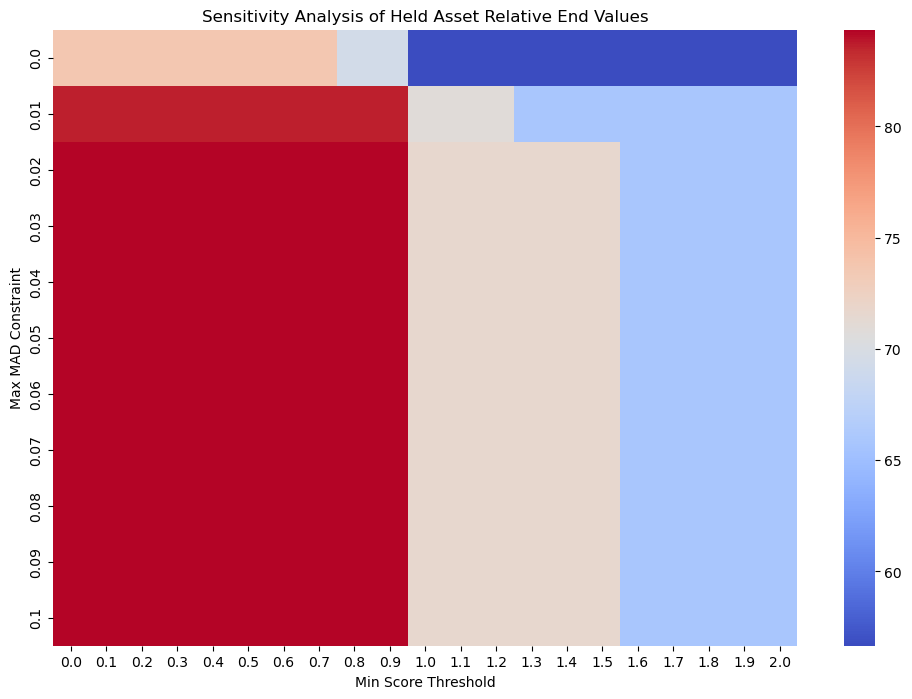

In [4]:
# Define hyperparameter ranges
max_mad_values = np.arange(0, 0.11, 0.01)  # Range: 0 to 0.1 with step size 0.01
min_score_threshold_values = np.arange(0, 2.1, 0.1)  # Range: 0 to 2 with step size 0.1
heatmap_results = np.zeros((len(max_mad_values), len(min_score_threshold_values)))

# Iterate over sensitivity grid
for i, max_mad in enumerate(max_mad_values):
    for k, min_score in enumerate(min_score_threshold_values):
        total_relative_end_value_across_periods = 0  # Reset for each (max_mad, min_score) combination

        for j in range(5):  # Iterate through 5 periods
            period_scores = {}
            period_mads = {}

            for asset in assets:
                data = all_asset_data[asset]
                subset = data.iloc[j * 80: (j + 1) * 80].copy().reset_index(drop=True)
                score, avg_return, mad, ema_diff = calculate_asset_score(subset.iloc[:60])

                period_scores[asset] = score
                period_mads[asset] = mad

            scores = np.array([period_scores[asset] for asset in assets])
            mads = np.array([period_mads[asset] for asset in assets])

            # Use the knapsack function with only the required 5 arguments
            selected_assets, total_score = knapsack_with_constraints(scores, mads, max_mad, min_score, assets)
            
            # Calculate the relative end value from selected assets
            period_end_value = 0
            for asset in selected_assets:
                data = all_asset_data[asset]
                subset = data.iloc[j * 80: (j + 1) * 80].copy().reset_index(drop=True)
                # Add the relative end value (difference between final and initial price)
                period_end_value += subset['Close/Last'].iloc[-1] - subset['Close/Last'].iloc[0]
                
            total_relative_end_value_across_periods += period_end_value  # Sum across periods

        heatmap_results[i, k] = total_relative_end_value_across_periods/5  # Store in heatmap

# Generate heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_results, xticklabels=np.round(min_score_threshold_values, 2), yticklabels=np.round(max_mad_values, 3), cmap="coolwarm", annot=False)
plt.xlabel("Min Score Threshold")
plt.ylabel("Max MAD Constraint")
plt.title("Sensitivity Analysis of Held Asset Relative End Values")
plt.show()

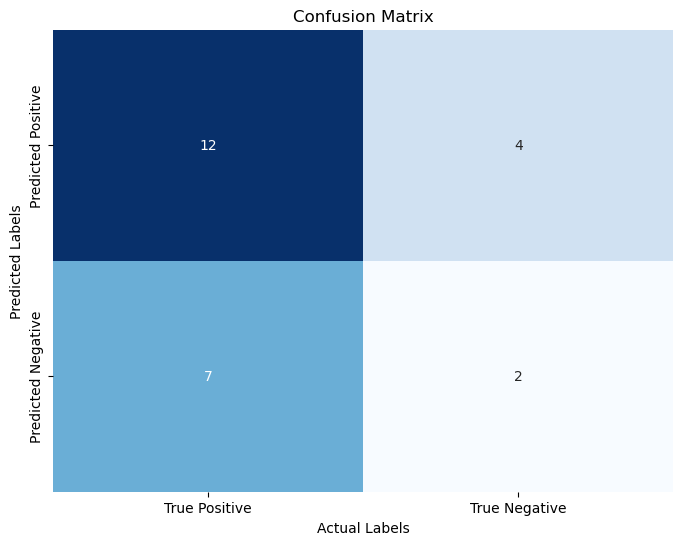


Performance Metrics:
Accuracy: 56.00%
Precision: 75.00%
Recall: 63.16%
F1 Score: 68.57%


In [5]:

# Calculate confusion matrix
confusion_matrix = evaluate_predictions(all_asset_data, assets)

# Create a DataFrame for the confusion matrix
confusion_df = pd.DataFrame({
    '': ['Predicted Positive', 'Predicted Negative'],
    'True Positive': [confusion_matrix['True Positive'], confusion_matrix['False Negative']],
    'True Negative': [confusion_matrix['False Positive'], confusion_matrix['True Negative']]
})

# Calculate performance metrics
total_predictions = sum(confusion_matrix.values())
accuracy = (confusion_matrix['True Positive'] + confusion_matrix['True Negative']) / total_predictions
precision = confusion_matrix['True Positive'] / (confusion_matrix['True Positive'] + confusion_matrix['False Positive']) if (confusion_matrix['True Positive'] + confusion_matrix['False Positive']) > 0 else 0
recall = confusion_matrix['True Positive'] / (confusion_matrix['True Positive'] + confusion_matrix['False Negative']) if (confusion_matrix['True Positive'] + confusion_matrix['False Negative']) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df.iloc[:, 1:], annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['True Positive', 'True Negative'],
            yticklabels=['Predicted Positive', 'Predicted Negative'])
plt.title('Confusion Matrix')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')

plt.show()

# Print performance metrics
print(f"\nPerformance Metrics:")
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 Score: {f1_score:.2%}")